In [1]:
import cv2
import os
import glob
import numpy as np
import pandas as pd
import spacy
import re
import string
import pytesseract
import imutils

from warnings import filterwarnings
filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

def show(image,figsize = (10,10)):
    plt.figure(figsize = figsize)
    plt.imshow(image)
    plt.title(f"Shape : {image.shape}")
    plt.axis("off")
    plt.show()
    
def convert_rbg(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

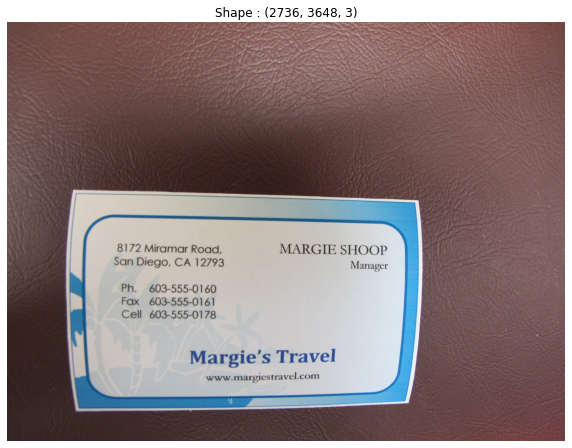

In [2]:
img_orig = cv2.imread("./images/015.jpg")
show(convert_rbg(img_orig))

## Scanning

### 1.Resize The Image and Set Aspect Ratio

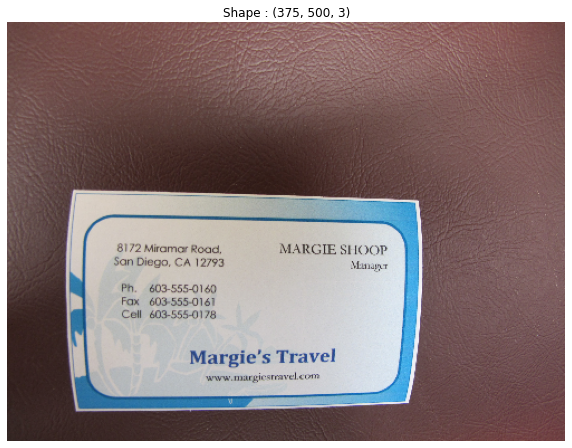

In [3]:
def resize(image,width = 500):
    h,w,c = image.shape
    
    height = int((h / w) * width)
    size = (width,height)
    image= cv2.resize(image,(width,height))
    return image, size

img,size = resize(img_orig)
show(convert_rbg(img))

### 2.Image Processing

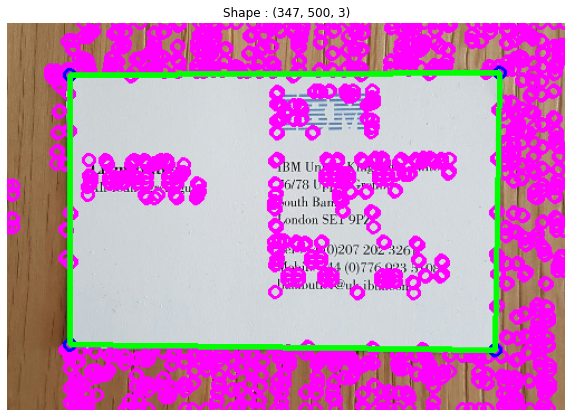

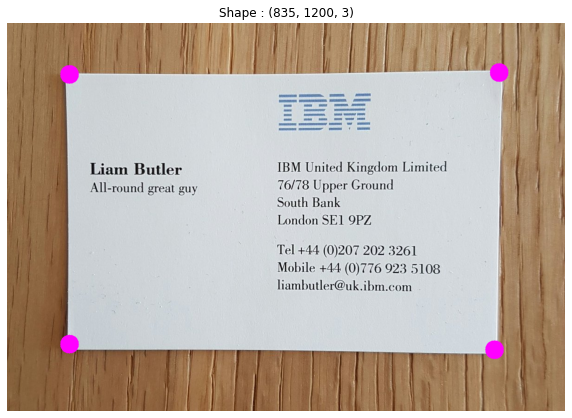

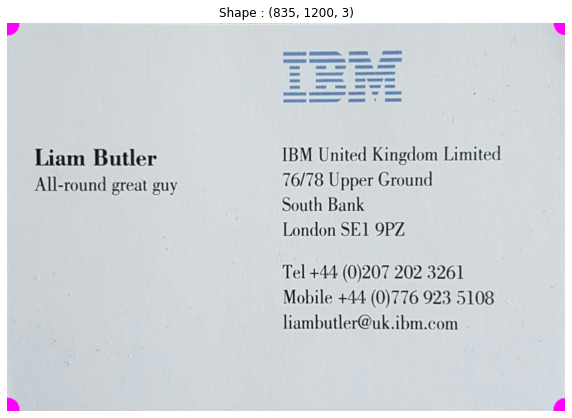

In [4]:
img_orig = cv2.imread("./images/001.jpg")
img,size = resize(img_orig,width=500)
img_ = img.copy()

####

detail = cv2.detailEnhance(img,sigma_s = 20 ,sigma_r = 0.15)
gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)

# edge_detect
edge_img = cv2.Canny(blur,75,200)

# morphological transform
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(edge_img,kernel,iterations = 1)
closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)

# find the contours
contours,findContours = cv2.findContours(closing,
                                        cv2.RETR_LIST,
                                        cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours,key = cv2.contourArea,reverse = True)

for contour in contours:
    for arr in contour:
        x,y = arr[0]
        cv2.circle(img_,(x,y),5,(255,0,255),2)

for contour in contours:
    peri = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,0.02*peri,True)
    if len(approx) == 4:
        for app in approx:
            x,y = app[0]    
            cv2.circle(img_,(x,y),5,(255,0,0),2)
        
        last_approx = approx
        break

cv2.drawContours(img_,[np.squeeze(last_approx)],-1,(0,255,0),3)
    
# find four points for original image           
def reorder(arr):
    
    myPointsNew = np.zeros_like(arr)
    
    myPoints = arr.reshape((4,2))
    add = myPoints.sum(1)
    
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    
    diff = np.diff(myPoints,axis = 1)
    
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    
    return np.squeeze(myPointsNew)

four_points = reorder(last_approx)

multiplier = img_orig.shape[1] / size[0]
four_points_orig = four_points * multiplier
four_points_orig = four_points_orig.astype(int)

for x,y in four_points_orig:
    cv2.circle(img_orig,(x,y),20,(255,0,255),-1)
    
def warpImg(image,points,w,h,pad = 20):
    
    pts1 = np.float32(points)
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    output = cv2.warpPerspective(image,matrix,(w,h))
    
    return output

w = img_orig.shape[1]
h = img_orig.shape[0]

output = warpImg(img_orig,four_points_orig,w,h)

show(convert_rbg(img_))
show(convert_rbg(img_orig))
show(convert_rbg(output))


## All Function

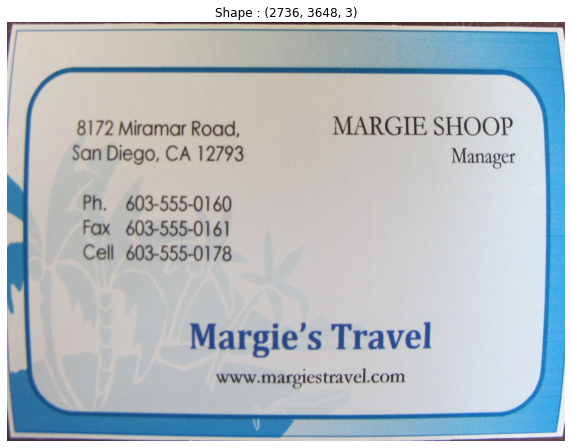

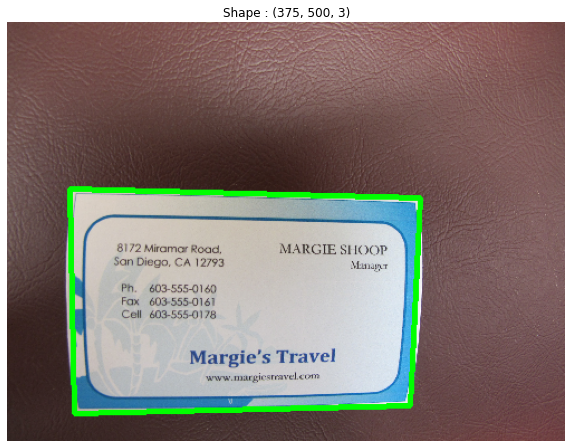

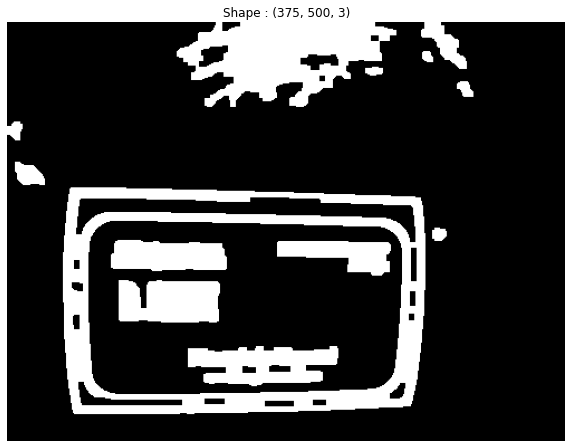

In [5]:
def resize(image,width = 500):
    h,w,c = image.shape
    
    height = int((h/w) * width)
    size = (width,height)
    image = cv2.resize(image,(width,height))
    return image ,size

def reorder(point):
    myPointNew = np.zeros_like(point)
    
    myPoints = point.reshape((4,2))
    
    add = myPoints.sum(1)
    
    myPointNew[0] = myPoints[np.argmin(add)]
    myPointNew[3] = myPoints[np.argmax(add)]
    
    diff = np.diff(myPoints,axis = 1)
    
    myPointNew[1] = myPoints[np.argmin(diff)]
    myPointNew[2] = myPoints[np.argmax(diff)]
    
    return myPointNew
    
def wrapImg(image,points,w,h):
    
    pts1 = np.float32(points)
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    output = cv2.warpPerspective(image,matrix,(w,h))
    return output

def document_scanner(image):
    
    img_re,size = resize(image)
    
    detail = cv2.detailEnhance(img_re,sigma_s = 20, sigma_r = 0.15)
    gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    
    edge_img = cv2.Canny(blur,75,200)
    
    kernel = np.ones((5,5),np.uint8)
    dilate = cv2.dilate(edge_img,kernel,iterations = 1)
    closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)
    
    contours,hierarchy = cv2.findContours(closing,
                                          cv2.RETR_LIST,
                                          cv2.CHAIN_APPROX_SIMPLE)
    
    contours = sorted(contours,key = cv2.contourArea,reverse=True)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 500:
            peri = cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            if len(approx) == 4:
                last_approx = approx
                break    

    cv2.drawContours(img_re,[last_approx],-1,(0,255,0),3)
    
    re_four_points = reorder(last_approx)
    #print(re_four_points.shape)
    
    multiplier = image.shape[1] / size[0]
    four_points_orig = re_four_points * multiplier
    four_points_orig = four_points_orig.astype(int)
    #print(four_points_orig.shape)
    
    w,h = image.shape[1],image.shape[0]
    
    wrap_img = wrapImg(image,four_points_orig,w,h)
    
    return wrap_img,four_points_orig,img_re,closing

img_org = cv2.imread("./images/015.jpg")
wrap,_,r,c = document_scanner(img_org)

show(convert_rbg(wrap))
show(convert_rbg(r))
show(convert_rbg(c))

## Magic Color

In [6]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

Text(0.5, 1.0, 'Magic: B = 50, C = 40')

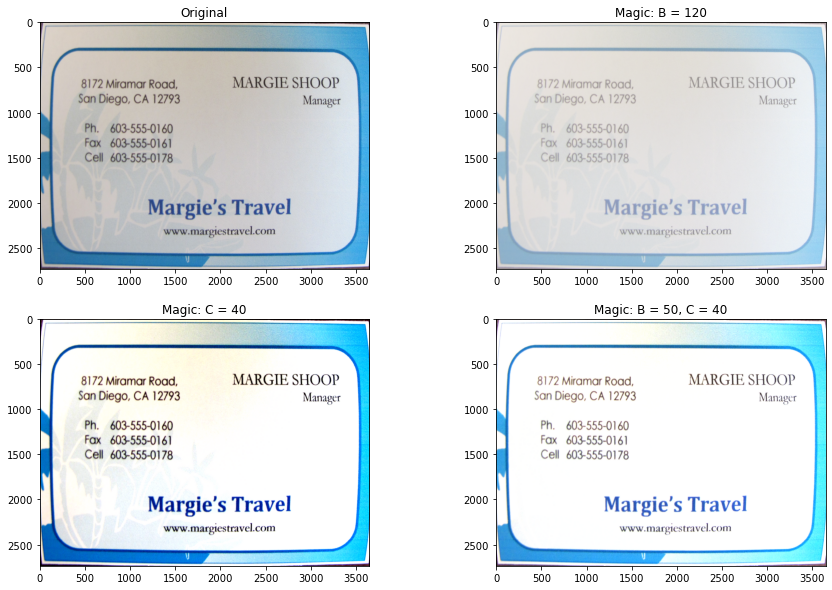

In [9]:
magic_image = apply_brightness_contrast(wrap,120,0)
magic_image_c1 = apply_brightness_contrast(wrap,0,40)
magic_image_c2 = apply_brightness_contrast(wrap,50,40)

plt.figure(figsize = (15,10))
plt.subplot(221)
plt.imshow(convert_rbg(wrap))
plt.title("Original")

plt.subplot(222)
plt.imshow(convert_rbg(magic_image))
plt.title("Magic: B = 120")

plt.subplot(223)
plt.imshow(convert_rbg(magic_image_c1))
plt.title("Magic: C = 40")

plt.subplot(224)
plt.imshow(convert_rbg(magic_image_c2))
plt.title("Magic: B = 50, C = 40")

## Predictions

In [10]:
from script import getPredictions

In [11]:
test = cv2.imread("./images/033.jpg")
wrap,_,_,_ = document_scanner(apply_brightness_contrast(test,40,50))
img_bb,results =getPredictions(wrap)

za btnaccess beyond the network limited jimit gandhi 20th floor, east exchange tower apemea 38 leighton road causeway bay, hong kong 91 22 5651 0827 91 22 5651 0826 91 98 2074 4226 igandhi@btnaccess.com www.btnaccess.com 4 pccw company none


{'NAME': [], 'ORG': ['Beyond The Network Limited', 'East Exchange', 'Pccw Company'], 'DES': [], 'PHONE': ['912256510827912256510826', '9820744226'], 'EMAIL': ['igandhi@btnaccess.com'], 'WEB': ['www.btnaccess.com']}


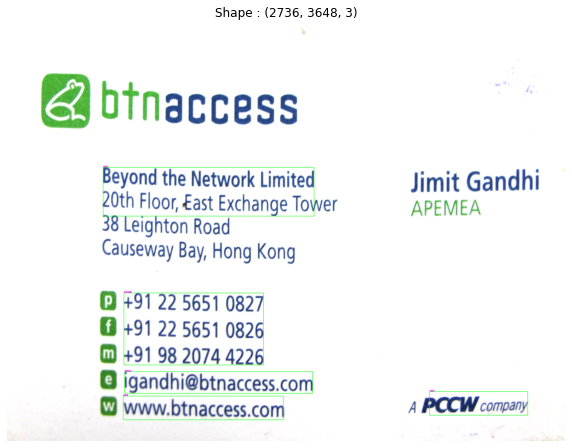

In [12]:
print(results)
show(convert_rbg(img_bb))